# Barlow Twins for Contrastive SSL

**Author:** [Abhiraam Eranti](https://github.com/dewball345)<br>
**Date created:** 11/4/21<br>
**Last modified:** 12/20/21<br>
**Description:** A keras implementation of Barlow Twins (constrastive SSL with redundancy reduction).

## Introduction

Self-supervised learning (SSL) is a relatively novel technique in which a model
learns from unlabeled data, and is often used when the data is corrupted or
if there is very little of it. A practical use for SSL is to create
intermediate embeddings that are learned from the data. These embeddings are
based on the dataset itself, with similar images having similar embeddings, and
vice versa. They are then attached to the rest of the model, which uses those
embeddings as information and effectively learns and makes predictions properly.
These embeddings, ideally, should contain as much information and insight about
the data as possible, so that the model can make better predictions. However,
a common problem that arises is that the model creates embeddings that are
redundant. For example, if two images are similar, the model will create
embeddings that are just a string of 1's, or some other value that
contains repeating bits of information. This is no better than a one-hot
encoding or just having one bit as the model’s representations; it defeats the
purpose of the embeddings, as they do not learn as much about the dataset as
possible. For other approaches, the solution to the problem was to carefully
configure the model such that it tries not to be redundant.


Barlow Twins is a new approach to this problem; while other solutions mainly
tackle the first goal of invariance (similar images have similar embeddings),
the Barlow Twins method also prioritizes the goal of reducing redundancy.

It also has the advantage of being much simpler than other methods, and its
model architecture is symmetric, meaning that both twins in the model do the
same thing. It is also near state-of-the-art on imagenet, even exceeding methods
like SimCLR.


One disadvantage of Barlow Twins is that it is heavily dependent on
augmentation, suffering major performance decreases in accuracy without them.

TL, DR: Barlow twins creates representations that are:

*   Invariant.
*   Not redundant, and carry as much info about the dataset.

Also, it is simpler than other methods.

This notebook can train a Barlow Twins model and reach up to
64% validation accuracy on the CIFAR-10 dataset.

![image](https://i.imgur.com/G6LnEPT.png)






### High-Level Theory


The model takes two versions of the same image(with different augmentations) as
input. Then it takes a prediction of each of them, creating representations.
They are then used to make a cross-correlation matrix.

Cross-correlation matrix:
```
(pred_1.T @ pred_2) / batch_size
```

The cross-correlation matrix measures the correlation between the output
neurons in the two representations made by the model predictions of the two
augmented versions of data. Ideally, a cross-correlation matrix should look
like an identity matrix if the two images are the same.

When this happens, it means that the representations:

1.   Are invariant. The diagonal shows the correlation between each
representation's neurons and its corresponding augmented one. Because the two
versions come from the same image, the diagonal of the matrix should show that
there is a strong correlation between them. If the images are different, there
shouldn't be a diagonal.
2.   Do not show signs of redundancy. If the neurons show correlation with a
non-diagonal neuron, it means that it is not correctly identifying similarities
between the two augmented images. This means that it is redundant.

Here is a good way of understanding in pseudocode(information from the original
paper):

```
c[i][i] = 1
c[i][j] = 0

where:
  c is the cross-correlation matrix
  i is the index of one representation's neuron
  j is the index of the second representation's neuron
```

Taken from the original paper: [Barlow Twins: Self-Supervised Learning via Redundancy
Reduction](https://arxiv.org/abs/2103.03230)

### References

Paper:
[Barlow Twins: Self-Supervised Learning via Redundancy
Reduction](https://arxiv.org/abs/2103.03230)

Original Implementation:
 [facebookresearch/barlowtwins](https://github.com/facebookresearch/barlowtwins)


## Setup

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 


In [2]:
import os

# slightly faster improvements, on the first epoch 30 second decrease and a 1-2 second
# decrease in epoch time. Overall saves approx. 5 min of training time

# Allocates two threads for a gpu private which allows more operations to be
# done faster
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf  # framework
from tensorflow import keras  # for tf.keras
import tensorflow_addons as tfa  # LAMB optimizer and gaussian_blur_2d function
import numpy as np  # np.random.random
import matplotlib.pyplot as plt  # graphs
import datetime  # tensorboard logs naming

import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# XLA optimization for faster performance(up to 10-15 minutes total time saved)
tf.config.optimizer.set_jit(True)

## Load the CIFAR-10 dataset

In [3]:
[
    (train_features, train_labels),
    (test_features, test_labels),
] = keras.datasets.cifar10.load_data()

train_features = train_features / 255.0
test_features = test_features / 255.0

170508288/170498071 [==============================] - 11s 0us/step


## Necessary Hyperparameters

In [4]:
# Batch size of dataset
BATCH_SIZE = 512
# Width and height of image
IMAGE_SIZE = 32

## Augmentation Utilities
The Barlow twins algorithm is heavily reliant on
Augmentation. One unique feature of the method is that sometimes, augmentations
probabilistically occur.

**Augmentations**

*   *RandomToGrayscale*: randomly applies grayscale to image 20% of the time
*   *RandomColorJitter*: randomly applies color jitter 80% of the time
*   *RandomFlip*: randomly flips image horizontally 50% of the time
*   *RandomResizedCrop*: randomly crops an image to a random size then resizes. This
happens 100% of the time
*   *RandomSolarize*: randomly applies solarization to an image 20% of the time
*   *RandomBlur*: randomly blurs an image 20% of the time

In [5]:

class Augmentation(keras.layers.Layer):
    """Base augmentation class.

    Base augmentation class. Contains the random_execute method.

    Methods:
        random_execute: method that returns true or false based
          on a probability. Used to determine whether an augmentation
          will be run.
    """

    def __init__(self):
        super(Augmentation, self).__init__()

    @tf.function
    def random_execute(self, prob: float) -> bool:
        """random_execute function.

        Arguments:
            prob: a float value from 0-1 that determines the
              probability.

        Returns:
            returns true or false based on the probability.
        """

        return tf.random.uniform([], minval=0, maxval=1) < prob


class RandomToGrayscale(Augmentation):
    """RandomToGrayscale class.

    RandomToGrayscale class. Randomly makes an image
    grayscaled based on the random_execute method. There
    is a 20% chance that an image will be grayscaled.

    Methods:
        call: method that grayscales an image 20% of
          the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a grayscaled version of the image 20% of the time
              and the original image 80% of the time.
        """

        if self.random_execute(0.2):
            x = tf.image.rgb_to_grayscale(x)
            x = tf.tile(x, [1, 1, 3])
        return x


class RandomColorJitter(Augmentation):
    """RandomColorJitter class.

    RandomColorJitter class. Randomly adds color jitter to an image.
    Color jitter means to add random brightness, contrast,
    saturation, and hue to an image. There is a 80% chance that an
    image will be randomly color-jittered.

    Methods:
        call: method that color-jitters an image 80% of
          the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Adds color jitter to image, including:
          Brightness change by a max-delta of 0.8
          Contrast change by a max-delta of 0.8
          Saturation change by a max-delta of 0.8
          Hue change by a max-delta of 0.2
        Originally, the same deltas of the original paper
        were used, but a performance boost of almost 2% was found
        when doubling them.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a color-jittered version of the image 80% of the time
              and the original image 20% of the time.
        """

        if self.random_execute(0.8):
            x = tf.image.random_brightness(x, 0.8)
            x = tf.image.random_contrast(x, 0.4, 1.6)
            x = tf.image.random_saturation(x, 0.4, 1.6)
            x = tf.image.random_hue(x, 0.2)
        return x


class RandomFlip(Augmentation):
    """RandomFlip class.

    RandomFlip class. Randomly flips image horizontally. There is a 50%
    chance that an image will be randomly flipped.

    Methods:
        call: method that flips an image 50% of
          the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Randomly flips the image.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a flipped version of the image 50% of the time
              and the original image 50% of the time.
        """

        if self.random_execute(0.5):
            x = tf.image.random_flip_left_right(x)
        return x


class RandomResizedCrop(Augmentation):
    """RandomResizedCrop class.

    RandomResizedCrop class. Randomly crop an image to a random size,
    then resize the image back to the original size.

    Attributes:
        image_size: The dimension of the image

    Methods:
        __call__: method that does random resize crop to the image.
    """

    def __init__(self, image_size):
        super(Augmentation, self).__init__()
        self.image_size = image_size

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Does random resize crop by randomly cropping an image to a random
        size 75% - 100% the size of the image. Then resizes it.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a randomly cropped image.
        """

        rand_size = tf.random.uniform(
            shape=[],
            minval=int(0.75 * self.image_size),
            maxval=1 * self.image_size,
            dtype=tf.int32,
        )

        crop = tf.image.random_crop(x, (rand_size, rand_size, 3))
        crop_resize = tf.image.resize(crop, (self.image_size, self.image_size))
        return crop_resize


class RandomSolarize(Augmentation):
    """RandomSolarize class.

    RandomSolarize class. Randomly solarizes an image.
    Solarization is when pixels accidentally flip to an inverted state.

    Methods:
        call: method that does random solarization 20% of the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Randomly solarizes the image.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a solarized version of the image 20% of the time
              and the original image 80% of the time.
        """

        if self.random_execute(0.2):
            # flips abnormally low pixels to abnormally high pixels
            x = tf.where(x < 10, x, 255 - x)
        return x


class RandomBlur(Augmentation):
    """RandomBlur class.

    RandomBlur class. Randomly blurs an image.

    Methods:
        call: method that does random blur 20% of the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Randomly solarizes the image.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a blurred version of the image 20% of the time
              and the original image 80% of the time.
        """

        if self.random_execute(0.2):
            s = np.random.random()
            return tfa.image.gaussian_filter2d(image=x, sigma=s)
        return x


class RandomAugmentor(keras.Model):
    """RandomAugmentor class.

    RandomAugmentor class. Chains all the augmentations into
    one pipeline.

    Attributes:
        image_size: An integer represing the width and height
          of the image. Designed to be used for square images.
        random_resized_crop: Instance variable representing the
          RandomResizedCrop layer.
        random_flip: Instance variable representing the
          RandomFlip layer.
        random_color_jitter: Instance variable representing the
          RandomColorJitter layer.
        random_blur: Instance variable representing the
          RandomBlur layer
        random_to_grayscale: Instance variable representing the
          RandomToGrayscale layer
        random_solarize: Instance variable representing the
          RandomSolarize layer

    Methods:
        call: chains layers in pipeline together
    """

    def __init__(self, image_size: int):
        super(RandomAugmentor, self).__init__()

        self.image_size = image_size
        self.random_resized_crop = RandomResizedCrop(image_size)
        self.random_flip = RandomFlip()
        self.random_color_jitter = RandomColorJitter()
        self.random_blur = RandomBlur()
        self.random_to_grayscale = RandomToGrayscale()
        self.random_solarize = RandomSolarize()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x = self.random_resized_crop(x)
        x = self.random_flip(x)
        x = self.random_color_jitter(x)
        x = self.random_blur(x)
        x = self.random_to_grayscale(x)
        x = self.random_solarize(x)

        x = tf.clip_by_value(x, 0, 1)
        return x


bt_augmentor = RandomAugmentor(IMAGE_SIZE)

## Data Loading

A class that creates the barlow twins' dataset.

The dataset consists of two copies of each image, with each copy receiving different
augmentations.

In [6]:

class BTDatasetCreator:
    """Barlow twins dataset creator class.

    BTDatasetCreator class. Responsible for creating the
    barlow twins' dataset.

    Attributes:
        options: tf.data.Options needed to configure a setting
          that may improve performance.
        seed: random seed for shuffling. Used to synchronize two
          augmented versions.
        augmentor: augmentor used for augmentation.

    Methods:
        __call__: creates barlow dataset.
        augmented_version: creates 1 half of the dataset.
    """

    def __init__(self, augmentor: RandomAugmentor, seed: int = 1024):
        self.options = tf.data.Options()
        self.options.threading.max_intra_op_parallelism = 1
        self.seed = seed
        self.augmentor = augmentor

    def augmented_version(self, ds: list) -> tf.data.Dataset:
        return (
            tf.data.Dataset.from_tensor_slices(ds)
            .shuffle(1000, seed=self.seed)
            .map(self.augmentor, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE)
            .with_options(self.options)
        )

    def __call__(self, ds: list) -> tf.data.Dataset:
        a1 = self.augmented_version(ds)
        a2 = self.augmented_version(ds)

        return tf.data.Dataset.zip((a1, a2)).with_options(self.options)


augment_versions = BTDatasetCreator(bt_augmentor)(train_features)

View examples of dataset.

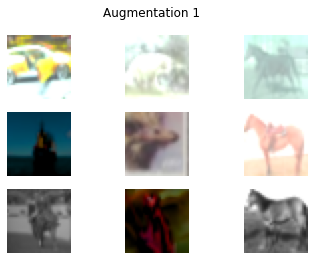

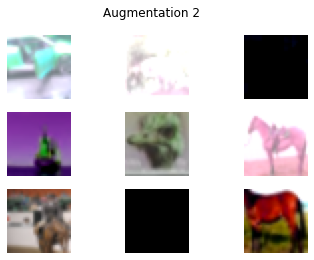

In [7]:
sample_augment_versions = iter(augment_versions)


def plot_values(batch: tuple):
    fig, axs = plt.subplots(3, 3)
    fig1, axs1 = plt.subplots(3, 3)

    fig.suptitle("Augmentation 1")
    fig1.suptitle("Augmentation 2")

    a1, a2 = batch

    # plots images on both tables
    for i in range(3):
        for j in range(3):
            # CHANGE(add / 255)
            axs[i][j].imshow(a1[3 * i + j])
            axs[i][j].axis("off")
            axs1[i][j].imshow(a2[3 * i + j])
            axs1[i][j].axis("off")

    plt.show()


plot_values(next(sample_augment_versions))

## Pseudocode of loss and model
The following sections follow the original author's pseudocode containing both model and
loss functions(see diagram below). Also contains a reference of variables used.

![pseudocode](https://i.imgur.com/Tlrootj.png)

Reference:

```
y_a: first augmented version of original image.
y_b: second augmented version of original image.
z_a: model representation(embeddings) of y_a.
z_b: model representation(embeddings) of y_b.
z_a_norm: normalized z_a.
z_b_norm: normalized z_b.
c: cross correlation matrix.
c_diff: diagonal portion of loss(invariance term).
off_diag: off-diagonal portion of loss(redundancy reduction term).
```

## BarlowLoss: barlow twins model's loss function

Barlow Twins uses the cross correlation matrix for its loss. There are two parts to the
loss function:

*   ***The invariance term***(diagonal). This part is used to make the diagonals of the
matrix into 1s. When this is the case, the matrix shows that the images are
correlated(same).
  * The loss function subtracts 1 from the diagonal and squares the values.
*   ***The redundancy reduction term***(off-diagonal). Here, the barlow twins loss
function aims to make these values zero. As mentioned before, it is redundant if the
representation neurons are correlated with values that are not on the diagonal.
  * Off diagonals are squared.

After this the two parts are summed together.




In [8]:

class BarlowLoss(keras.losses.Loss):
    """BarlowLoss class.

    BarlowLoss class. Creates a loss function based on the cross-correlation
    matrix.

    Attributes:
        batch_size: the batch size of the dataset
        lambda_amt: the value for lambda(used in cross_corr_matrix_loss)

    Methods:
        __init__: gets instance variables
        call: gets the loss based on the cross-correlation matrix
          make_diag_zeros: Used in calculating off-diagonal section
          of loss function; makes diagonals zeros.
        cross_corr_matrix_loss: creates loss based on cross correlation
          matrix.
    """

    def __init__(self, batch_size: int):
        """__init__ method.

        Gets the instance variables

        Arguments:
            batch_size: An integer value representing the batch size of the
              dataset. Used for cross correlation matrix calculation.
        """

        super(BarlowLoss, self).__init__()
        self.lambda_amt = 5e-3
        self.batch_size = batch_size

    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        """get_off_diag method.

        Makes the diagonals of the cross correlation matrix zeros.
        This is used in the off-diagonal portion of the loss function,
        where we take the squares of the off-diagonal values and sum them.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix_loss method.

        Gets the loss based on the cross correlation matrix.
        We want the diagonals to be 1's and everything else to be
        zeros to show that the two augmented images are similar.

        Loss function procedure:
        take the diagonal of the cross-correlation matrix, subtract by 1,
        and square that value so no negatives.

        Take the off-diagonal of the cc-matrix(see get_off_diag()),
        square those values to get rid of negatives and increase the value,
        and multiply it by a lambda to weight it such that it is of equal
        value to the optimizer as the diagonal(there are more values off-diag
        then on-diag)

        Take the sum of the first and second parts and then sum them together.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        # subtracts diagonals by one and squares them(first part)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)

        # takes off diagonal, squares it, multiplies with lambda(second part)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt

        # sum first and second parts together
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)

        return loss

    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        """normalize method.

        Normalizes the model prediction.

        Arguments:
            output: the model prediction.

        Returns:
            Returns a normalized version of the model prediction.
        """

        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(
            output, axis=0
        )

    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix method.

        Creates a cross correlation matrix from the predictions.
        It transposes the first prediction and multiplies this with
        the second, creating a matrix with shape (n_dense_units, n_dense_units).
        See build_twin() for more info. Then it divides this with the
        batch size.

        Arguments:
            z_a_norm: A normalized version of the first prediction.
            z_b_norm: A normalized version of the second prediction.

        Returns:
            Returns a cross correlation matrix.
        """
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size

    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        """call method.

        Makes the cross-correlation loss. Uses the CreateCrossCorr
        class to make the cross corr matrix, then finds the loss and
        returns it(see cross_corr_matrix_loss()).

        Arguments:
            z_a: The prediction of the first set of augmented data.
            z_b: the prediction of the second set of augmented data.

        Returns:
            Returns a (rank-0) tf.Tensor that represents the loss.
        """

        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        loss = self.cross_corr_matrix_loss(c)
        return loss


## Barlow Twins' Model Architecture
The model has two parts:

*   The encoder network, which is a resnet-34.
*   The projector network, which creates the model embeddings.
   * This consists of an MLP with 3 dense-batchnorm-relu layers.

Resnet encoder network implementation:

In [9]:

class ResNet34:
    """Resnet34 class.

        Responsible for the Resnet 34 architecture.
    Modified from
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
        View their website for more information.
    """

    def identity_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def convolutional_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same", strides=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # Processing Residue with conv(1,1)
        x_skip = tf.keras.layers.Conv2D(filter, (1, 1), strides=(2, 2))(x_skip)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def __call__(self, shape=(32, 32, 3)):
        # Step 1 (Setup Input Layer)
        x_input = tf.keras.layers.Input(shape)
        x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
        # Step 2 (Initial Conv layer along with maxPool)
        x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
        # Define size of sub-blocks and initial filter size
        block_layers = [3, 4, 6, 3]
        filter_size = 64
        # Step 3 Add the Resnet Blocks
        for i in range(4):
            if i == 0:
                # For sub-block 1 Residual/Convolutional block not needed
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
            else:
                # One Residual/Convolutional Block followed by Identity blocks
                # The filter size will go on increasing by a factor of 2
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
        # Step 4 End Dense Network
        x = tf.keras.layers.AveragePooling2D((2, 2), padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
        return model


In [10]:
input_shape = (32, 32, 3)
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [11]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [12]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [13]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [14]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [15]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
print("patch-merging : ",x)
x = layers.GlobalAveragePooling1D()(x)
print("global average pooling : ", x)

model = keras.Model(input, x)

patch-merging :  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='patch_merging/dense_9/Tensordot:0', description="created by layer 'patch_merging'")
global average pooling :  KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='global_average_pooling1d/Mean:0', description="created by layer 'global_average_pooling1d'")


In [16]:
def build_encoder():
    
    input = layers.Input(input_shape)
    x = layers.RandomCrop(image_dimension, image_dimension)(input)
    x = layers.RandomFlip("horizontal")(x)
    x = PatchExtract(patch_size)(x)
    x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
    x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
    )(x)
    x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
    )(x)
    x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
    print("patch-merging : ",x)
    x = layers.GlobalAveragePooling1D()(x)
    print("global average pooling : ", x)
    #output = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(input, x)
    
    return model
    
   
    

Projector network:

In [17]:

def build_twin() -> keras.Model:
    """build_twin method.

    Builds a barlow twins model consisting of an encoder(resnet-34)
    and a projector, which generates embeddings for the images

    Returns:
        returns a barlow twins model
    """

    # number of dense neurons in the projector
    n_dense_neurons = 5000
    resnet = ResNet34()()
    print("resnet---34",resnet.layers[-1].output,resnet.layers[-2].output)
    # encoder network
    resnet = build_encoder()
    print("swin-next-line..............", resnet)
    print("resent.layers[-1].output............",resnet.layers[-1].output, resnet.layers[-2].output)
    last_layer = resnet.layers[-1].output

    # intermediate layers of the projector network
    n_layers = 2
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{i}")
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f"projector_bn_{i}")(x)
        x = tf.keras.layers.ReLU(name=f"projector_relu_{i}")(x)

    x = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{n_layers}")(x)

    model = keras.Model(resnet.input, x)
    return model


## Training Loop Model

See pseudocode for reference.

In [18]:

class BarlowModel(keras.Model):
    """BarlowModel class.

    BarlowModel class. Responsible for making predictions and handling
    gradient descent with the optimizer.

    Attributes:
        model: the barlow model architecture.
        loss_tracker: the loss metric.

    Methods:
        train_step: one train step; do model predictions, loss, and
            optimizer step.
        metrics: Returns metrics.
    """

    def __init__(self):
        super(BarlowModel, self).__init__()
        self.model = build_twin()
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, batch: tf.Tensor) -> tf.Tensor:
        """train_step method.

        Do one train step. Make model predictions, find loss, pass loss to
        optimizer, and make optimizer apply gradients.

        Arguments:
            batch: one batch of data to be given to the loss function.

        Returns:
            Returns a dictionary with the loss metric.
        """

        # get the two augmentations from the batch
        y_a, y_b = batch

        with tf.GradientTape() as tape:
            # get two versions of predictions
            z_a, z_b = self.model(y_a, training=True), self.model(y_b, training=True)
            loss = self.loss(z_a, z_b)

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


## Model Training

* Used the LAMB optimizer, instead of ADAM or SGD.
* Similar to the LARS optimizer used in the paper, and lets the model converge much
faster than other methods.
* Expected training time: 1 hour 30 min. Go and eat a snack or take a nap or something.

resnet---34 KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'") KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='average_pooling2d/AvgPool:0', description="created by layer 'average_pooling2d'")
patch-merging :  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='patch_merging_1/dense_19/Tensordot:0', description="created by layer 'patch_merging_1'")
global average pooling :  KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='global_average_pooling1d_1/Mean:0', description="created by layer 'global_average_pooling1d_1'")
swin-next-line.............. <keras.engine.functional.Functional object at 0x7f94e62b4d10>
resent.layers[-1].output............ KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='global_average_pooling1d_1/Mean:0', d

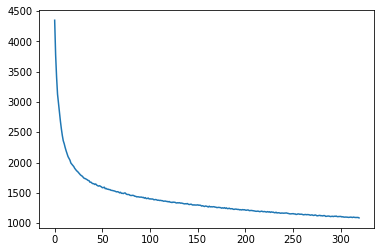

In [19]:
# sets up model, optimizer, loss

bm = BarlowModel()
# chose the LAMB optimizer due to high batch sizes. Converged MUCH faster
# than ADAM or SGD
optimizer = tfa.optimizers.LAMB()
loss = BarlowLoss(BATCH_SIZE)

bm.compile(optimizer=optimizer, loss=loss)

# Expected training time: 1 hours 30 min

history = bm.fit(augment_versions, epochs=320)
plt.plot(history.history["loss"])
plt.show()

## Evaluation

**Linear evaluation:** to evaluate the model's performance, we add
a linear dense layer at the end and freeze the main model's weights, only letting the
dense layer to be tuned. If the model actually learned something, then the accuracy would
be significantly higher than random chance.

**Accuracy on CIFAR-10** : 64% for this notebook. This is much better than the 10% we get
from random guessing.

In [20]:
# Approx: 64% accuracy with this barlow twins model.

xy_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

model = keras.models.Sequential(
    [
        bm.model,
        keras.layers.Dense(
            10, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.02)
        ),
    ]
)

model.layers[0].trainable = False

linear_optimizer = tfa.optimizers.LAMB()
model.compile(
    optimizer=linear_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(xy_ds, epochs=100, validation_data=test_ds)

Epoch 1/100
97/97 [==============================] - 12s 66ms/step - loss: 2.5017 - accuracy: 0.2673 - val_loss: 2.2279 - val_accuracy: 0.4055
Epoch 2/100
97/97 [==============================] - 4s 45ms/step - loss: 2.0253 - accuracy: 0.5019 - val_loss: 1.8506 - val_accuracy: 0.5765
Epoch 3/100
97/97 [==============================] - 4s 45ms/step - loss: 1.7236 - accuracy: 0.6020 - val_loss: 1.6322 - val_accuracy: 0.6241
Epoch 4/100
97/97 [==============================] - 4s 45ms/step - loss: 1.5461 - accuracy: 0.6349 - val_loss: 1.5063 - val_accuracy: 0.6421
Epoch 5/100
97/97 [==============================] - 4s 45ms/step - loss: 1.4423 - accuracy: 0.6507 - val_loss: 1.4277 - val_accuracy: 0.6466
Epoch 6/100
97/97 [==============================] - 4s 45ms/step - loss: 1.3745 - accuracy: 0.6567 - val_loss: 1.3722 - val_accuracy: 0.6522
Epoch 7/100
97/97 [==============================] - 4s 45ms/step - loss: 1.3272 - accuracy: 0.6610 - val_loss: 1.3361 - val_accuracy: 0.6519
Epoch

## Conclusion

*   Barlow Twins is a simple and concise method for contrastive and self-supervised
learning.
*   With this resnet-34 model architecture, we were able to reach 62-64% validation
accuracy.

## Use-Cases of Barlow-Twins(and contrastive learning in General)

*   Semi-supervised learning: You can see that this model gave a 62-64% boost in accuracy
when it wasn't even trained with the labels. It can be used when you have little labeled
data but a lot of unlabeled data.
* You do barlow twins training on the unlabeled data, and then you do secondary training
with the labeled data.

## Helpful links

* [Paper](https://arxiv.org/abs/2103.03230)
* [Original Pytorch Implementation](https://github.com/facebookresearch/barlowtwins)
* [Sayak Paul's
Implementation](https://colab.research.google.com/github/sayakpaul/Barlow-Twins-TF/blob/main/Barlow_Twins.ipynb#scrollTo=GlWepkM8_prl).
* Thanks to Sayak Paul for his implementation. It helped me with debugging and
comparisons of accuracy, loss.
* [resnet34
implementation](https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2)
  * Thanks to Yashowardhan Shinde for writing the article.

